In [2]:
a = torch.randn(3, 2)
print(a)

tensor([[ 1.6831,  0.6330],
        [ 1.1286, -0.8109],
        [-0.1811,  1.0483]])


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import copy
import math
import sys
import time

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.max_mol = 11100
args.max_peaks = 150
args.max_atoms = 250
args.max_partial_charge = 4.0
args.min_partial_charge = -1.0
args.max_intensity = 1000
args.min_intensity = 0
args.max_shift = -3
args.min_shift = 20
args.num_feature = 59
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [4]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

# 1. Pre-Processing

In [9]:
def read_nmrDB_pickle(file_name, num_mol, max_peak):
    df = pd.read_pickle(file_name).head(num_mol)
    
    inchi_list = df['inchi'].tolist()
    peaks_list = df['peaks'].tolist()
    
    for i, inchi in enumerate(inchi_list):
        if '\n' in inchi:
            inchi_list[i] = inchi.split('\n')[0]
    
    inchi_list_final = list()
    shift_list = list()
    intensity_list = list()
    num_peak_list = list()
    for idx, peaks in enumerate(peaks_list):
        isValid = True
        shifts = [0] * max_peak
        intensities = [0] * max_peak
        for i, peak in enumerate(peaks):
            shifts[i] = float(peak[1])
            intensities[i] = float(peak[2])
            if intensities[i] < 0:
                isValid = False
        if isValid:
            shift_list.append(shifts)
            intensity_list.append(intensities)
            num_peak_list.append(len(peaks))
            inchi_list_final.append(inchi_list[idx])
        
    return inchi_list_final, shift_list, intensity_list, num_peak_list

def normalize_peak(shift_list, intensity_list, args):
    for i in range(len(shift_list)):
        for j in range(len(shift_list[i])):
            shift = shift_list[i][j]
            intensity = intensity_list[i][j]
            shift_list[i][j] = (shift-args.min_shift)/(args.max_shift-args.min_shift)
            intensity_list[i][j] = (intensity-args.min_intensity)/(args.max_intensity-args.min_intensity)

def convert_inchi_to_graph(inchi_list, max_atoms, num_feature):
    adj = list()
    adj_norm = list()
    features = list()
    for inchi in inchi_list:
        # Generate mol from InChI code.
        iMol = Chem.inchi.MolFromInchi(inchi)
        # Add H atoms to the mol.
        iMol = Chem.rdmolops.AddHs(iMol)
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        if (iAdjTmp.shape[0] <= max_atoms):
            # Preprocess features
            iFeature = np.zeros((max_atoms, num_feature))
            iFeatureTmp = []
            AllChem.ComputeGasteigerCharges(iMol)
            for atom in iMol.GetAtoms():
                iFeatureTmp.append(atom_feature(atom))
            iFeature[0:len(iFeatureTmp), 0:num_feature] = iFeatureTmp
            features.append(iFeature)
            # Preprocess adjacency matrix
            iAdj = np.zeros((max_atoms, max_atoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)
    
    return features, adj

def normalized_partial_charge_of_atom(atom):
    partial_charge = float(atom.GetProp("_GasteigerCharge"))
    partial_charge = (partial_charge-args.min_partial_charge)/(args.max_partial_charge-args.min_partial_charge)
    return partial_charge

def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()] +
                    [normalized_partial_charge_of_atom(atom)])    # (40, 6, 5, 6, 1, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))

In [12]:
class NMRDataset(Dataset):
    
    def __init__(self, list_feature, list_adj, list_shift, list_intensity, list_num_peak):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_shift = list_shift
        self.list_intensity = list_intensity
        self.list_num_peak = list_num_peak
        
    def __len__(self):
        return len(self.list_feature)
    
    def __getitem__(self, index):
        feature = self.list_feature[index]
        adj = self.list_adj[index]
        shift = self.list_shift[index]
        intensity = self.list_intensity[index]
        num_peak = self.list_num_peak[index]
        return feature, adj, shift, intensity, num_peak
    
class NumPeakDataset(Dataset):
    
    def __init__(self, list_feature, list_adj, list_num_peak):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_num_peak = list_num_peak
        
    def __len__(self):
        return len(self.list_feature)
    
    def __getitem__(self, index):
        feature = self.list_feature[index]
        adj = self.list_adj[index]
        num_peak = self.list_num_peak[index]
        return feature, adj, num_peak
    
def partition(list_feature, list_adj, list_shift, list_intensity, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    
    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    shift_train = list_shift[:num_train]
    intensity_train = list_intensity[:num_train]
    num_peak_train = list_num_peak[:num_train]
    
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    shift_val = list_shift[num_train:num_train + num_val]
    intensity_val = list_intensity[num_train:num_train + num_val]
    num_peak_val = list_num_peak[num_train:num_train + num_val]

    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    shift_test = list_shift[num_total - num_test:]
    intensity_test = list_intensity[num_total - num_test:]
    num_peak_test = list_num_peak[num_total - num_test:]

    train_set = NMRDataset(feature_train, adj_train, shift_train, intensity_train, num_peak_train)
    val_set = NMRDataset(feature_val, adj_val, shift_val, intensity_val, num_peak_val)
    test_set = NMRDataset(feature_test, adj_test, shift_test, intensity_test, num_peak_test)
    
    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

def partition_num_peak(list_feature, list_adj, list_num_peak, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)
    
    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    num_peak_train = list_num_peak[:num_train]
    
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    num_peak_val = list_num_peak[num_train:num_train + num_val]
    
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_total - num_test:]
    num_peak_test = list_num_peak[num_total - num_test:]
    
    train_set = NumPeakDataset(feature_train, adj_train, num_peak_train)
    val_set = NumPeakDataset(feature_val, adj_val, num_peak_val)
    test_set = NumPeakDataset(feature_test, adj_test, num_peak_test)
    
    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [13]:
list_inchi, list_shift, list_intensity, list_num_peak = read_nmrDB_pickle('nmrDB_deduplicated.pkl', args.max_mol, args.max_peaks)
list_feature, list_adj = convert_inchi_to_graph(list_inchi, args.max_atoms, args.num_feature)
normalize_peak(list_shift, list_intensity, args)
dict_partition = partition(list_feature, list_adj, list_shift, list_intensity, args)
dict_partition_num_peak = partition_num_peak(list_feature, list_adj, list_num_peak, args)

In [8]:
print(len(list_feature), len(list_adj), len(list_num_peak))

11098 11098 11098


# 2. Model Construction

In [22]:
class SkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(SkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        out = in_x + out_x
        return out

In [23]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, out_dim):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.linear_coef_in = nn.Linear(out_dim, out_dim)
        self.linear_coef_out = nn.Linear(out_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, in_x, out_x):
        if (self.in_dim != self.out_dim):
            in_x = self.linear(in_x)
        z = self.gate_coefficient(in_x, out_x)
        out = torch.mul(z, out_x) + torch.mul(1.0-z, in_x)
        return out
            
    def gate_coefficient(self, in_x, out_x):
        x1 = self.linear_coef_in(in_x)
        x2 = self.linear_coef_out(out_x)
        return self.sigmoid(x1+x2)

In [24]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, output_dim, num_head):
        super(Attention, self).__init__()
        
        self.num_head = num_head
        self.atn_dim = output_dim // num_head
        
        self.linears = nn.ModuleList()
        self.corelations = nn.ParameterList()
        for i in range(self.num_head):
            self.linears.append(nn.Linear(in_dim, self.atn_dim))
            corelation = torch.FloatTensor(self.atn_dim, self.atn_dim)
            nn.init.xavier_uniform_(corelation)
            self.corelations.append(nn.Parameter(corelation))
            
        self.tanh = nn.Tanh()
        
    def forward(self, x, adj):
        heads = list()
        for i in range(self.num_head):
            x_transformed = self.linears[i](x)
            alpha = self.attention_matrix(x_transformed, self.corelations[i], adj)
            x_head = torch.matmul(alpha, x_transformed)
            heads.append(x_head)
        output = torch.cat(heads, dim=2)
        return output
            
    def attention_matrix(self, x_transformed, corelation, adj):
        x = torch.einsum('akj,ij->aki', (x_transformed, corelation))
        alpha = torch.matmul(x, torch.transpose(x_transformed, 1, 2))
        alpha = torch.mul(alpha, adj)
        alpha = self.tanh(alpha)
        return alpha

In [25]:
class GCNLayer(nn.Module):
    
    def __init__(self, in_dim, out_dim, n_atom, act=None, bn=False, atn=False, num_head=1, dropout=0):
        super(GCNLayer, self).__init__()
        
        self.use_bn = bn
        self.use_atn = atn
        self.linear = nn.Linear(in_dim, out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.bn = nn.BatchNorm1d(n_atom)
        self.attention = Attention(out_dim, out_dim, num_head)
        self.activation = act
        self.dropout_rate = dropout
        self.dropout = nn.Dropout2d(self.dropout_rate)
        
    def forward(self, x, adj):
        out = self.linear(x)
        if self.use_atn:
            out = self.attention(out, adj)
        else:
            out = torch.matmul(adj, out)
        if self.use_bn:
            out = self.bn(out)
        if self.activation != None:
            out = self.activation(out)
        if self.dropout_rate > 0:
            out = self.dropout(out)
        return out, adj

In [26]:
class GCNBlock(nn.Module):
    
    def __init__(self, n_layer, in_dim, hidden_dim, out_dim, n_atom, bn=True, atn=True, num_head=1, sc='gsc', dropout=0):
        super(GCNBlock, self).__init__()
        
        self.layers = nn.ModuleList()
        for i in range(n_layer):
            self.layers.append(GCNLayer(in_dim if i==0 else hidden_dim,
                                        out_dim if i==n_layer-1 else hidden_dim,
                                        n_atom,
                                        nn.ReLU() if i!=n_layer-1 else None,
                                        bn,
                                        atn,
                                        num_head,
                                        dropout))
        self.relu = nn.ReLU()
        if sc=='gsc':
            self.sc = GatedSkipConnection(in_dim, out_dim)
        elif sc=='sc':
            self.sc = SkipConnection(in_dim, out_dim)
        elif sc=='no':
            self.sc = None
        else:
            assert False, "Wrong sc type."
        
    def forward(self, x, adj):
        residual = x
        for i, layer in enumerate(self.layers):
            out, adj = layer((x if i==0 else out), adj)
        if self.sc != None:
            out = self.sc(residual, out)
        out = self.relu(out)
        return out, adj

In [27]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, 1)
        if self.activation != None:
            out = self.activation(out)
        return out

In [28]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, act=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = act
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        return out

In [29]:
class NumPeakNet(nn.Module):
    
    def __init__(self, args):
        super(NumPeakNet, self).__init__()
        
        self.blocks = nn.ModuleList()
        for i in range(args.n_block):
            self.blocks.append(GCNBlock(args.n_layer,
                                        args.in_dim if i==0 else args.hidden_dim,
                                        args.hidden_dim,
                                        args.hidden_dim,
                                        args.n_atom,
                                        args.bn,
                                        args.atn,
                                        args.num_head,
                                        args.sc,
                                        args.dropout))
        self.readout = ReadOut(args.hidden_dim, 
                               args.pred_dim1,
                               act=nn.ReLU())
        self.pred1 = Predictor(args.pred_dim1,
                               args.pred_dim2,
                               act=nn.ReLU())
        self.pred2 = Predictor(args.pred_dim2,
                               args.pred_dim3,
                               act=nn.Tanh())
        self.pred3 = Predictor(args.pred_dim3,
                               args.out_dim)
        
    def forward(self, x, adj):
        for i, block in enumerate(self.blocks):
            out, adj = block((x if i==0 else out), adj)
        out = self.readout(out)
        out = self.pred1(out)
        out = self.pred2(out)
        out = self.pred3(out)
        return out

# 3. Train, Validate, and Test

In [30]:
# list_num_peak

In [31]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device).float()
        list_adj = torch.tensor(batch[1]).to(device).float()
        list_logP = torch.tensor(batch[2]).to(device).float()
        list_logP = list_logP.view(-1,1)
                
        model.train()
        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
       
        bar.update(len(list_feature))

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [32]:
def validate(model, device, criterion, data_val, bar, args):
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            list_logP = list_logP.view(-1,1)

            model.eval()
            list_pred_logP = model(list_feature, list_adj)
            list_pred_logP.require_grad = False
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(len(list_feature))

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [33]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device).float()
            list_adj = torch.tensor(batch[1]).to(device).float()
            list_logP = torch.tensor(batch[2]).to(device).float()
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)

            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(np.array(logP_total)-np.array(pred_logP_total))
        
    return mae, std, logP_total, pred_logP_total

In [34]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    
    model = NumPeakNet(args)
    model.to(device)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer,
                                          step_size=args.step_size,
                                          gamma=args.gamma)

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition_num_peak['train'], 
                            batch_size=args.batch_size,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition_num_peak['val'],
                          batch_size=args.batch_size,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        scheduler.step()
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition_num_peak['test'],
                           batch_size=args.batch_size,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

# 4. Visualization

In [35]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [36]:
def plot_performance_bar(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    bar_mae = sns.barplot(x=var1, y='mae', hue=var2, data=df_result, ax=ax[0])
    bar_std = sns.barplot(x=var1, y='std', hue=var2, data=df_result, ax=ax[1])
    
    bar_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    bar_std.set_title('Std depends on ' + var1 + ' vs ' + var2)
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2) 

In [37]:
def plot_loss(df_result, var1, var2, ylim):
    def plot(x, ylim=1.0, **kwargs):
        plt.plot(x[0], **kwargs)
        plt.ylim(0.0, ylim)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', ylim=ylim, label='Train Loss')
    g.map(plot, 'list_val_loss', ylim=ylim, color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.legend()
    plt.show()

In [38]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3, s=2)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.9)
    plt.show()

In [39]:
args.batch_size = 100
args.lr = 0.001
args.l2_coef = 0
args.optim = 'Adam'
args.epoch = 8
args.n_block = 3
args.n_layer = 1
args.n_atom = args.max_atoms
args.in_dim = args.num_feature
args.hidden_dim = 256
args.pred_dim1 = 256
args.pred_dim2 = 128
args.pred_dim3 = 256
args.out_dim = args.max_peaks
args.bn = True
args.sc = 'gsc'
args.atn = False
args.num_head = 16
args.dropout = 0
args.step_size = 10
args.gamma = 0.1

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [40]:
list_lr = [0.01]
list_n_block = [2]
var1 = "lr"
var2 = "n_block"

dict_result = dict()
n_iter = len(list_n_block)*len(list_lr)*args.epoch*(len(dict_partition_num_peak['train'])+len(dict_partition_num_peak['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)

for lr in list_lr:
    for n_block in list_n_block:
        args.lr = lr
        args.n_block = n_block
        args.exp_name = var1+':'+str(lr)+'/'+var2+':'+str(n_block)
        result = vars(experiment(dict_partition_num_peak, device, bar, args))
        print(args.exp_name + " took " + str(int(args.time_required)) + "seconds.")
        dict_result[args.exp_name] = copy.deepcopy(result)
        
        torch.cuda.empty_cache()
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('lr vs n_block.JSON', orient='table')

lr:0.01/n_block:2 took 54seconds.



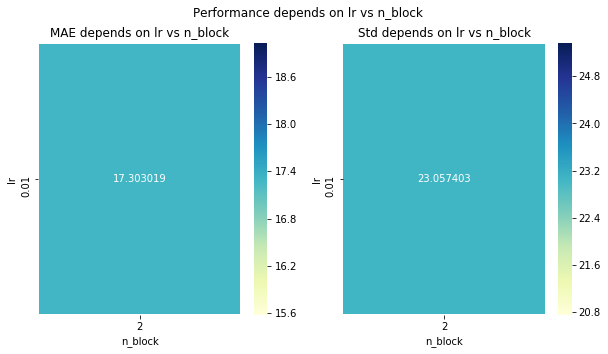

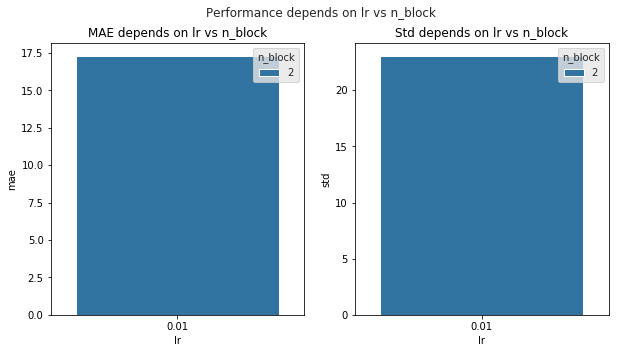

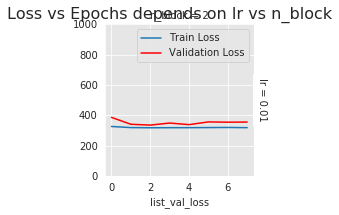

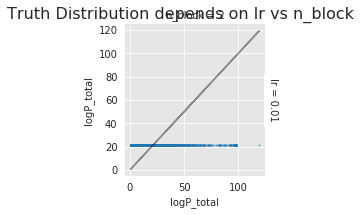

In [41]:
df_result = pd.read_json('lr vs n_block.JSON', orient='table')

plot_performance(df_result, var1, var2)
plot_performance_bar(df_result, var1, var2)
plot_loss(df_result, var1, var2, 1000)
plot_distribution(df_result, var1, var2)

In [43]:
df_result['pred_logP_total'].tolist()

[[21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.2289199829,
  21.228919982